Utworzony model sieci zilustrowany na (Rys. 1) ma za zadanie odzwierciedlać proces związany z produkcją trzech różnych klas butelek (np. przezroczystych, zielonych, brązowych). 
W projekcie sieci można wyróżnić sześć różnych systemów o różnorodnych typach, wśród których można wyróżnić:
*	Typ I – Stacja FIFO, w której zgłoszenia, które pierwsze przyszło do kolejki zostaje najwcześniej obsłużone. Rozkład czasów obsługi wszystkich klas jest identyczny 
i wykładniczy
*	Typ II – Stacja PS (ang. procesor sharing) składająca się z jednego kanału obsługi. Zakłada że zgłoszenia różnych klas mogą mieć inne wymagania odnośnie obsługi. Rozkład czasów obsługi może zostać przedstawiony w postaci rozkładu Cox’a.
*	Typ III – Stacja IS (ang. infinite server), w której dostępna jest nieograniczona liczba kanałów obsługi, przez co zgłoszenia nie tworzą kolejki. </br>

W utworzonym modelu sieci typy stacji zostały dobrane w taki sposób, aby ich działanie dla zadanej funkcjonalności systemu miało odzwierciedlenie w rzeczywistości. Połączenia pomiędzy kolejnymi systemami oraz ich prawdopodobieństwa zostały umieszczone 
na (Rys. 1).


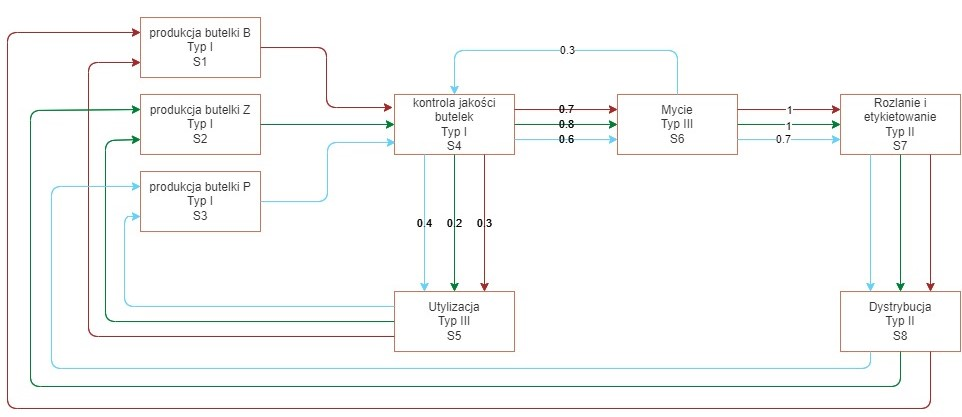

In [1]:
import numpy as np
import math

class SummationMethod:
    def __init__(self) -> None:
        self.r = 3 # klasy: butelki B/Z/P
        self.n = 6 # systemy
        self.service_type = np.array([1, 1, 3, 3, 2, 2]) # typy poszczególnych systemów
        self.m = np.array([3, 1, 1, 1, 1, 1]) # kanały obsługi
        self.mi = np.array([[3, 3, 3],              # 1
                            [5, 5, 5],              # 1
                            [2, 1, 2],              # 3
                            [2, 1, 2],              # 3
                            [2, 2, 3],              # 2
                            [3, 3, 1]]              # 2
                            )                          # size = n x r

        self.p = np.array([[
                            [0, 1,   0,   0, 0, 0],
                            [0, 0, 0.3, 0.7, 0, 0],
                            [1, 0,   0,   0, 0, 0],
                            [0, 0,   0,   0, 1, 0],
                            [0, 0,   0,   0, 0, 1],
                            [1, 0,   0,   0, 0, 0]
                                                        ],
                            [
                            [0, 1,   0,   0, 0, 0],
                            [0, 0, 0.2, 0.8, 0, 0],
                            [1, 0,   0,   0, 0, 0],
                            [0, 0,   0,   0, 1, 0],
                            [0, 0,   0,   0, 0, 1],
                            [1, 0,   0,   0, 0, 0]
                                                        ],
                            [
                            [0, 1,   0,   0, 0, 0],
                            [0, 0, 0.4, 0.6, 0, 0],
                            [1, 0,   0,   0, 0, 0],
                            [0, 0.3, 0,   0, 0.7, 0],
                            [0, 0,   0,   0, 0, 1],
                            [1, 0,   0,   0, 0, 0]
                                                        ]]) # prawdopodobieństwa przejścia size = r x (n x n)
        
        self.K = np.array([5, 2, 3]) # średnia liczba zgłoszeń dla klas
        self.epsajlon = 1e-05
        self.e = np.zeros(shape=(self.n, self.r)) # średnia liczba wizyt
        self.lambdas = np.array([self.epsajlon] * self.r)
        self.num_of_iterations = 200 # liczba iteracji dla metody iteracyjnej
        self.T_ir = np.zeros(shape=(self.n, self.r))
        self.K_ir = np.zeros(shape=(self.n, self.r))
        self.calculate_E()

    def calculate_Ro_ir(self, i, r):
        Ro_ir = 0
        if self.service_type[i] == 1: # Typ 1, (m_i >= 1)
            Ro_ir = self.lambdas[r] * self.e[i, r] / (self.m[i] * self.mi[i, r])
        else: # Typ 2, 3, 4
            Ro_ir = self.lambdas[r] * self.e[i, r] / self.mi[i, r]
        return Ro_ir

    def calculate_E(self): # (4.23) rozwiązujemy równanie liniowe
        for r in range(self.r):
            A = self.p[r].T - np.diag([0] + [1] * (self.n - 1))
            b = np.array([1] + [0] * (self.n - 1))
            x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
            self.e[:, r] = x.T
    
    def calculate_Ro_i(self, i): # Ro_i = E (Ro_ir)
        Ro_i = 0
        for r in range(self.r):
            if self.service_type[i] == 1: # Typ 1: (m_i >= 1)
                Ro_i += self.lambdas[r] * self.e[i, r] / (self.m[i] * self.mi[i, r]) # dla m >= 1
            else: # Typ (2, 3, 4)
                Ro_i += self.lambdas[r] * self.e[i, r] / (self.mi[i, r])
        return Ro_i
    
    def calculate_P_mi(self, i, ro_i):
        sum_ = 0
        m_i = int(self.m[i])
        for ki in range(m_i):
            sum_ += ((m_i * ro_i) ** ki) / math.factorial(ki)
        factor1 = ((m_i * ro_i) ** self.m[i]) / (math.factorial(m_i) * (1 - ro_i))
        factor2 = 1 / (sum_ + ((m_i * ro_i) ** self.m[i]) / math.factorial(m_i) * 1 / (1 - ro_i))
        return factor1 * factor2

    def calcucate_Fix_ir(self, ro_i, i, r):
        e_ir = self.e[i, r]
        mi_ir = self.mi[i, r]
        if self.service_type[i] in [1, 2, 4]:
            m_i = int(self.m[i])
            K = np.sum(self.K)
            if self.service_type[i] == 1 and m_i > 1:
                P_mi = self.calculate_P_mi(i, ro_i)
                return e_ir / mi_ir + ((e_ir / (mi_ir * m_i)) / (1 - ro_i * (K - m_i - 1) / (K - m_i))) * P_mi
            else:
                return (e_ir / mi_ir) / (1 - ro_i * (K-1) / K)
        else:
            return e_ir / mi_ir
    
    def run_iteration_method_for_Lambda_r(self):
        current_error = None
        for i in range(self.num_of_iterations):
            if current_error is not None and current_error <= self.epsajlon:
                print(f"terminate {i}")
                break
            else:
                prev_lambdas_r = self.lambdas.copy()
                self._calculate_Lambda_r()
                current_error = self.calculate_Error(prev_lambdas_r, self.lambdas)
    
    def _calculate_Lambda_r(self): # (4.55)
        for r in range(self.r):
            sum_of_Fix_ir = 0
            for i in range(self.n):
                Ro_i = self.calculate_Ro_i(i)
                sum_of_Fix_ir += self.calcucate_Fix_ir(Ro_i, i, r)
            if sum_of_Fix_ir == 0: # dzielenie przez zero
                self.lambdas[r] = 0
            else:
                self.lambdas[r] = self.K[r] / sum_of_Fix_ir # (4.55)
    
    def calculate_Error(self, prev_lambda_r, lambda_r):
        return np.sqrt(np.sum((prev_lambda_r - lambda_r) ** 2))
    
    def calculate_K_ir(self):
        K_matrix = np.zeros(shape=(self.n, self.r), dtype=np.float32)
        for i in range(self.n):
            for r in range(self.r):
                mi_ir = self.mi[i, r]
                if self.service_type[i] in [1, 2, 4]:
                    K = np.sum(self.K)
                    # print(f"K = {K}")
                    ro_i = self.calculate_Ro_i(i)
                    # print(f"Ro_{i} = {ro_i}")
                    ro_ir = self.calculate_Ro_ir(i, r)
                    # print(f"Ro_{i}{r} = {ro_ir}")
                    m_i = self.m[i]
                    if self.service_type[i] == 1 and m_i > 1:
                        P_mi = self.calculate_P_mi(i, ro_i)
                        # print(f"P_mi = {P_mi}")
                        K_matrix[i, r] = m_i * ro_ir + (ro_ir / (1 - ro_i * (K - m_i - 1) / (K - m_i))) * P_mi
                        # print(f"K_{i}{r} = {K - m_i - 1}")
                    else:
                        K_matrix[i, r] = ro_ir / (1 - ro_i * (K-1) / K)
                else:
                    lambda_ir = self.lambdas[r] * self.e[i, r]
                    K_matrix[i, r] = lambda_ir / mi_ir
        self.K_ir = K_matrix
        return K_matrix
    
    def calculate_T_ir(self):
        for i in range(self.n):
            for r in range(self.r):
                lambda_ir = self.lambdas[r] * self.e[i, r]
                if lambda_ir:
                    self.T_ir[i, r] = self.K_ir[i, r] / lambda_ir
                else:
                    self.T_ir[i, r] = 0
    

if __name__ == '__main__':
    SummationMethodHandler = SummationMethod()
    print("Matrix e_ir: ", SummationMethodHandler.e)
    SummationMethodHandler.run_iteration_method_for_Lambda_r()
    print("Lambdas: ", SummationMethodHandler.lambdas)
    SummationMethodHandler.calculate_K_ir()
    print("K_ir: ", SummationMethodHandler.K_ir)
    print("K: ", np.sum(SummationMethodHandler.K_ir, axis=0))
    SummationMethodHandler.calculate_T_ir()
    print("T_ir: ", SummationMethodHandler.T_ir)


Matrix e_ir:  [[1.         1.         1.        ]
 [1.         1.         1.2195122 ]
 [0.3        0.2        0.48780488]
 [0.7        0.8        0.73170732]
 [0.7        0.8        0.51219512]
 [0.7        0.8        0.51219512]]
terminate 47
Lambdas:  [1.43675509 0.46518417 0.72810658]
K_ir:  [[0.4928849  0.1595834  0.24978004]
 [0.5772156  0.1868875  0.3567274 ]
 [0.21551326 0.09303684 0.17758697]
 [0.5028643  0.37214735 0.26638046]
 [1.875827   0.6941078  0.463715  ]
 [1.3356403  0.4942238  1.4858001 ]]
K:  [4.9999456 1.9999866 2.99999  ]
T_ir:  [[0.34305422 0.34305425 0.34305423]
 [0.40174948 0.40174949 0.40174951]
 [0.49999999 1.00000004 0.5       ]
 [0.50000002 1.00000004 0.5       ]
 [1.86514236 1.86514238 1.24342827]
 [1.32803259 1.32803262 3.98409789]]
